<a href="https://colab.research.google.com/github/stefisha/StefanVelickovic_Omega_DS_InvestmentRounds/blob/main/Investment_rounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
file_path = '/content/drive/MyDrive/Data Science Task - VegaIT/python_task_data.csv'

In [ ]:
df = pd.read_csv(file_path)

### Loading the dataset

In [ ]:
df.head()

,permalink,company,numEmps,category,city,state,fundedDate,raisedAmt,raisedCurrency,round
0,lifelock,LifeLock,NaN,web,Tempe,AZ,1-May-07,6850000,USD,b
1,lifelock,LifeLock,NaN,web,Tempe,AZ,1-Oct-06,6000000,USD,a
2,lifelock,LifeLock,NaN,web,Tempe,AZ,1-Jan-08,25000000,USD,c
3,mycityfaces,MyCityFaces,7.0,web,Scottsdale,AZ,1-Jan-08,50000,USD,seed
4,flypaper,Flypaper,NaN,web,Phoenix,AZ,1-Feb-08,3000000,USD,a


In [ ]:
print(df.columns)

Index(['permalink', 'company', 'numEmps', 'category', 'city', 'state',
       'fundedDate', 'raisedAmt', 'raisedCurrency', 'round'],
      dtype='object')


### Preprocessing

In [ ]:
# Fill missing values for numEmps using the median
df['numEmps'] = df['numEmps'].fillna(df['numEmps'].median())

# Convert fundedDate to datetime format
if 'fundedDate' in df.columns:
    df['fundedDate'] = pd.to_datetime(df['fundedDate'], errors='coerce')

    # Create a new column for fundedYear from the fundedDate
    df['fundedYear'] = df['fundedDate'].dt.year

    # Drop rows with missing fundedDate values
    df = df.dropna(subset=['fundedDate'])

    # Drop unwanted columns
    df = df.drop(columns=['permalink', 'company', 'fundedDate'])

# Convert categorical columns into dummy variables
columns_to_dummy = ['category', 'city', 'state', 'raisedCurrency']
available_columns = [col for col in columns_to_dummy if col in df.columns]

# Apply get_dummies only to available columns
df = pd.get_dummies(df, columns=available_columns, drop_first=True)

We might consider dropping these features:
### 1. Dropping `permalink`:
- **Reason**: The `permalink` column typically contains a unique identifier for each company or record, similar to an ID. While this is useful for tracking records, it doesn't contribute to the predictive power of a machine learning model.
- **Why drop?**: Since it doesn't provide any meaningful information for prediction, keeping it can add unnecessary complexity.

### 2. Dropping `company`:
- **Reason**: The `company` column usually contains the name of the company. The company name is categorical data, but it likely has no direct influence on the prediction target (such as funding round type).
- **Why drop?**: Similar to `permalink`, the company name doesn't add value to the model. Using it could overfit the model to specific company names, which is not desirable in most cases.

### 3. Dropping `fundedDate`:
- **Reason**: In the preprocessing step, you extract the year (`fundedYear`) from the `fundedDate`, which is likely more relevant for prediction.
- **Why drop?**: After extracting the useful part (the year), the full date isn't needed for the prediction task, and keeping it might add unnecessary complexity. The exact timestamp of the funding event typically does not provide additional predictive power compared to just the year.

### Summary:
- **`permalink` and `company`**: These columns act as identifiers and are not helpful for predicting the target variable.
- **`fundedDate`**: We already extracted the important information (the year), so the full date is no longer needed.

In [ ]:
print(df.columns)

Index(['numEmps', 'raisedAmt', 'round', 'fundedYear', 'category_cleantech',
       'category_consulting', 'category_hardware', 'category_mobile',
       'category_other', 'category_software',
       ...
       'state_OR', 'state_PA', 'state_RI', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_WA', 'raisedCurrency_EUR', 'raisedCurrency_USD'],
      dtype='object', length=237)


In [ ]:
df.head()

,numEmps,raisedAmt,round,fundedYear,category_cleantech,category_consulting,category_hardware,category_mobile,category_other,category_software,...,state_OR,state_PA,state_RI,state_TN,state_TX,state_UT,state_VA,state_WA,raisedCurrency_EUR,raisedCurrency_USD
0,20.0,6850000,b,2007,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,20.0,6000000,a,2006,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,20.0,25000000,c,2008,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,7.0,50000,seed,2008,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,20.0,3000000,a,2008,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Modeling

In [ ]:
# Defining the features (X) and target variable (y)
X = df.drop(columns=['round'])
y = df['round']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode the target variable (round)
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a basic Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Output the results
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Model Accuracy: 45.21%
Classification Report:
              precision    recall  f1-score   support

           a       0.53      0.61      0.57       122
       angel       0.41      0.33      0.37        27
           b       0.32      0.42      0.36        74
           c       0.43      0.22      0.29        27
           d       0.33      0.10      0.15        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.67      0.42      0.51        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.45       292
   macro avg       0.30      0.23      0.25       292
weighted avg       0.45      0.45      0.44       292



In [ ]:
def calculate_and_print_metrics(y_true, y_pred):
    """
    Calculate and print evaluation metrics: accuracy, precision, recall, and F1-score.

    Parameters:
    - y_true: The true labels
    - y_pred: The predicted labels
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }

    # Print the metrics
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1_score']:.2f}")

In [ ]:
from xgboost import XGBClassifier
# Step 6: Train the XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = model.predict(X_test)

In [ ]:
# Calculate and print the metrics
calculate_and_print_metrics(y_test, y_pred)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.49
Precision: 0.46
Recall: 0.49
F1 Score: 0.47

Classification Report:
              precision    recall  f1-score   support

           a       0.59      0.69      0.63       122
       angel       0.50      0.30      0.37        27
           b       0.39      0.46      0.42        74
           c       0.24      0.19      0.21        27
           d       0.00      0.00      0.00        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.61      0.46      0.52        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.49       292
   macro avg       0.26      0.23      0.24       292
weighted avg       0.46      0.49      0.47       292



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

### 1. Handle Class Imbalance
- **Problem**: The dataset might have imbalanced classes where some funding rounds (e.g., 'angel', 'seed') have fewer samples compared to others (e.g., 'a', 'b').
- **Solution**: Apply **SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic samples for underrepresented classes and balance the dataset.

### 2. Hyperparameter Tuning
- **Problem**: The default hyperparameters may not be optimal for the XGBoost model, limiting its performance.
- **Solution**: Use **RandomizedSearchCV** or **GridSearchCV** to tune hyperparameters and find the best set of parameters for the model, improving accuracy, precision, recall, and F1-score.

### 3. Cross-Validation
- **Problem**: The performance on a single test set might not generalize well to unseen data.
- **Solution**: Use **cross-validation** (such as 5-fold or 10-fold) to evaluate the model on multiple subsets of the data and get a more robust performance estimate.

### 4. Feature Scaling
- **Problem**: Features with large variations in value (like `raisedAmt`) can negatively impact the model's performance.
- **Solution**: Normalize the feature values using **MinMaxScaler** or **StandardScaler**, especially for algorithms sensitive to feature magnitude (like XGBoost).

### 5. Feature Importance and Selection
- **Problem**: Some features might not contribute much to the prediction, while others might have more predictive power.
- **Solution**: Analyze **feature importance** after training and consider selecting the most important features or removing less important ones to improve model efficiency.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint, uniform

In [ ]:
# Step 4: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Step 5: Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_resampled = scaler.fit_transform(X_resampled)

In [ ]:
# Step 6: Hyperparameter Tuning for XGBoost using RandomizedSearchCV
xgb = XGBClassifier(random_state=42, use_label_encoder=False)

In [ ]:
# Define parameter distributions for tuning
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0)
}

In [ ]:
# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb, param_distributions, n_iter=20, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1531, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
  

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1c55c54b80>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a1c55c54b20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a1c55c54eb0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1c55c56830>},
                   random_state=42, scoring='accuracy')

In [ ]:
# Best model after hyperparameter tuning
best_model = random_search.best_estimator_

In [ ]:
# Step 7: Cross-Validation (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:36:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:36:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:36:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [ ]:
# Step 8: Evaluate model on test set
X_test = scaler.transform(X_test)  # Apply scaling to the test set
y_pred = best_model.predict(X_test)

In [ ]:
# Print cross-validation score
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Print metrics for the test set
calculate_and_print_metrics(y_test, y_pred)

Cross-Validation Accuracy: 86.22%
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98


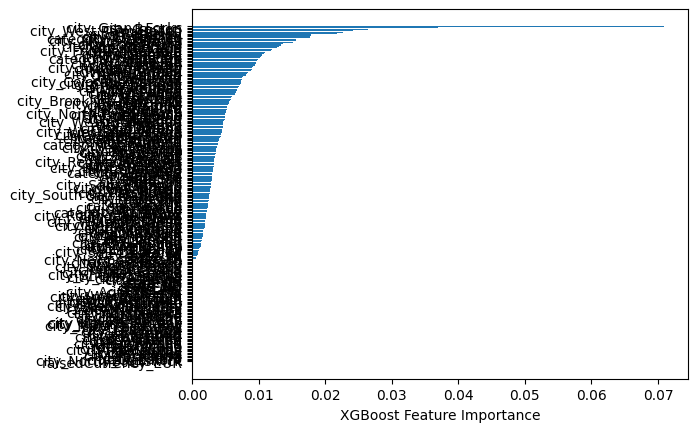

In [ ]:
# Step 9: Feature Importance
import matplotlib.pyplot as plt

# Plot feature importance
xgb_importances = best_model.feature_importances_
sorted_idx = xgb_importances.argsort()

plt.barh(df.columns[sorted_idx], xgb_importances[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show()

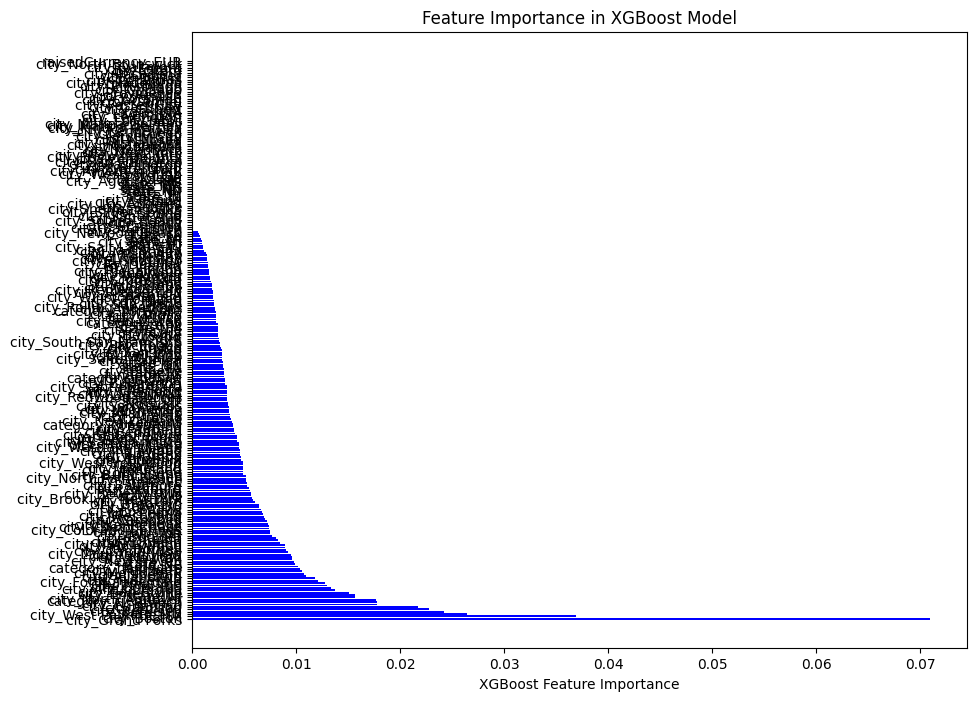

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 9: Feature Importance Analysis
# Get the feature importances from the trained XGBoost model
xgb_importances = best_model.feature_importances_

# Sort the feature importances in descending order
sorted_idx = np.argsort(xgb_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(df.columns[sorted_idx], xgb_importances[sorted_idx], color='blue')
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance in XGBoost Model")
plt.show()

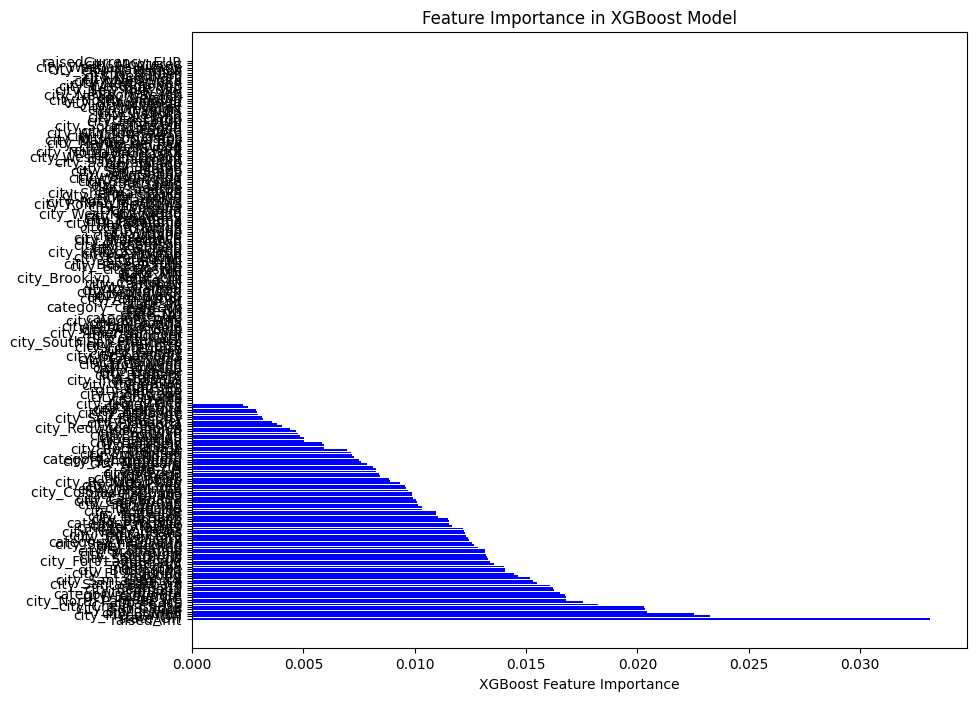

Selected Features for Top 10:
raisedAmt                int64
state_OH                  bool
city_Pleasanton           bool
city_Bothell              bool
city_Ir vine              bool
city_San Carlos           bool
city_Chevy Chase          bool
state_NE                  bool
city_North Palm Beach     bool
state_DC                  bool
dtype: object

Accuracy with Top 10 Features: 51.03%

Classification Report:
              precision    recall  f1-score   support

           a       0.62      0.73      0.67       122
       angel       0.39      0.26      0.31        27
           b       0.41      0.51      0.46        74
           c       0.16      0.11      0.13        27
           d       0.00      0.00      0.00        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.67      0.50      0.57        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy with Top 20 Features: 49.32%

Classification Report:
              precision    recall  f1-score   support

           a       0.59      0.71      0.64       122
       angel       0.36      0.15      0.21        27
           b       0.39      0.46      0.42        74
           c       0.19      0.15      0.17        27
           d       0.00      0.00      0.00        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.65      0.62      0.64        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.49       292
   macro avg       0.24      0.23      0.23       292
weighted avg       0.45      0.49      0.46       292

Selected Features for Top 30:
raisedAmt                  int64
state_OH                    bool
city_Pleasanton             bool
city_Bothell                bool
city_Ir vine                bool
city_San Carlos             bool
city

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy with Top 30 Features: 48.97%

Classification Report:
              precision    recall  f1-score   support

           a       0.61      0.66      0.63       122
       angel       0.39      0.26      0.31        27
           b       0.39      0.49      0.43        74
           c       0.19      0.15      0.17        27
           d       0.25      0.10      0.14        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.68      0.62      0.65        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.49       292
   macro avg       0.28      0.25      0.26       292
weighted avg       0.47      0.49      0.48       292

Selected Features for Top 50:
raisedAmt                  int64
state_OH                    bool
city_Pleasanton             bool
city_Bothell                bool
city_Ir vine                bool
city_San Carlos             bool
city

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy with Top 50 Features: 48.63%

Classification Report:
              precision    recall  f1-score   support

           a       0.60      0.66      0.63       122
       angel       0.40      0.22      0.29        27
           b       0.39      0.49      0.43        74
           c       0.11      0.07      0.09        27
           d       0.25      0.10      0.14        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.70      0.67      0.68        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.49       292
   macro avg       0.27      0.25      0.25       292
weighted avg       0.46      0.49      0.47       292



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Assuming you have `xgb_importances` from the previously trained model
# Sort feature importances in descending order
sorted_idx = np.argsort(xgb_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(df.columns[sorted_idx], xgb_importances[sorted_idx], color='blue')
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance in XGBoost Model")
plt.show()

# Step 6: Test with different numbers of top features
for N in [10, 20, 30, 50]:
    # Select the top N features
    top_features = df.columns[sorted_idx][:N]

    # Ensure 'round' (target variable) is not part of the selected features
    top_features = [feature for feature in top_features if feature != 'round']

    # Ensure all selected features are numeric
    print(f"Selected Features for Top {N}:")
    print(df[top_features].dtypes)  # Check the data types of the selected features

    # Verify all features are numeric and properly encoded
    if df[top_features].select_dtypes(include=['object']).empty:
        # If no object (string) dtype columns remain, proceed with scaling and model training
        scaler = MinMaxScaler()
        X_top_scaled = scaler.fit_transform(df[top_features])

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42)

        # Train the XGBoost model
        model = XGBClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\nAccuracy with Top {N} Features: {accuracy * 100:.2f}%")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
    else:
        print(f"Error: Non-numeric data types found in the top {N} features.")
        break  # Exit the loop if there are non-numeric features


In [ ]:
import joblib

# Assuming best_model is your trained model
joblib.dump(best_model, 'model.pkl')

['model.pkl']

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the column names
joblib.dump(X_train.columns, 'expected_columns.pkl')

# Now, convert to NumPy arrays for model training (if needed)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)